In [3]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score

In [4]:
torch.__version__

'1.10.1'

In [5]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import shutil
import subprocess
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

plt.ion() 

In [6]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# MobileNetV3 + Distillation + Quantization)

In [7]:
SOURCE_PATH = 'C:\PythonDev\Projects\sex_clothes_classifier\data\_data\_data'

In [10]:
lamoda_labels = pd.read_csv(f'{SOURCE_PATH}\lamoda\pages_info.tsv', sep='\t')
wildberries_labels = pd.read_csv(f'{SOURCE_PATH}\wildberries\pages_info.tsv', sep='\t')
wildberries_labels = wildberries_labels.drop(wildberries_labels[wildberries_labels['gender'] == 'женские / для девочек / мом фит / бананы / балоны / багги / слоучи / кюлоты'].index)
wildberries_labels = wildberries_labels.drop(wildberries_labels[wildberries_labels['category'] == '/catalog/48833592/detail.aspx?targetUrl=GP'].index)
wildberries_labels['item_id'] = wildberries_labels['item_id'].fillna(0.0).astype(int)

In [11]:
classification_labels = pd.concat([lamoda_labels, wildberries_labels], axis=0)
classification_labels = classification_labels.drop(classification_labels[classification_labels.item_id==0].index)
classification_labels['item_id'] = classification_labels['item_id'].fillna(0.0).astype(str)
classification_labels.reset_index(inplace=True)
del classification_labels['index']
classification_labels = classification_labels.sample(frac=1).reset_index(drop=True)

In [12]:
classification_labels.head()

,gender,category,brand,subcategory,item_url,img_url,item_id,price,price_discount,popular_flg,premium,size,colour,material,novice_flg,rating,num_reviews,description
0,женский,водолазка,zarina,водолазка,/p/mp002xw093q7/clothes-zarina-vodolazka/,http://a.lmcdn.ru/img236x341/M/P/MP002XW093Q7_...,MP002XW093Q7,2399.0,1079.0,0,non-premium,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,женский,кардиган,daffy world,кардиган,/catalog/25100422/detail.aspx?targetUrl=GP,https://images.wbstatic.net/c516x688/new/25100...,25100422,3900.0,2067.0,1,non-premium,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,женский,рубашка,love republic,рубашка,/p/mp002xw0akf2/clothes-loverepublic-rubashka/,http://a.lmcdn.ru/img236x341/M/P/MP002XW0AKF2_...,MP002XW0AKF2,3499.0,0.0,1,non-premium,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,мужской,рубашка,atlas for men,рубашка,/catalog/50665308/detail.aspx?targetUrl=GP,https://images.wbstatic.net/c516x688/new/50660...,50665308,4199.0,2362.0,0,non-premium,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,женский,свитер,spaceberry,свитер,/catalog/41267560/detail.aspx?targetUrl=GP,https://images.wbstatic.net/c516x688/new/41260...,41267560,6500.0,3139.0,0,non-premium,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
classification_labels.category.unique()

array(['водолазка', 'кардиган', 'рубашка', 'свитер', 'поло', 'юбка',
       'брюки', 'джемпер', 'топ', 'жилет', 'блузка', 'футболка', 'костюм',
       'свитшот', 'джинсы', 'шорты', 'пиджак', 'платье', 'жакет',
       'пуловер', 'толстовка', 'купальник'], dtype=object)

In [14]:
len(classification_labels.category.unique())

22

# Cleaning data

In [15]:
transform_train = transforms.Compose([
         transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
         transforms.Resize((224, 224)),                           
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
])

In [16]:
train_data = datasets.ImageFolder('C:\PythonDev\Projects\sex_clothes_classifier\data\\types_of_images\\train', transform=transform_train)
test_data = datasets.ImageFolder('C:\PythonDev\Projects\sex_clothes_classifier\data\\types_of_images\\valid', transform=transform_val)

In [17]:
train_data

Dataset ImageFolder
    Number of datapoints: 177074
    Root location: C:\PythonDev\Projects\sex_clothes_classifier\data\types_of_images\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [18]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle = True, pin_memory=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle = False, pin_memory=True, num_workers=4)

In [19]:
for batch in train_loader:
    for elem in batch:
        print(elem.size())
    break

torch.Size([128, 3, 224, 224])
torch.Size([128])


In [20]:
test_dataiter = iter(test_loader)
images, labels = test_dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

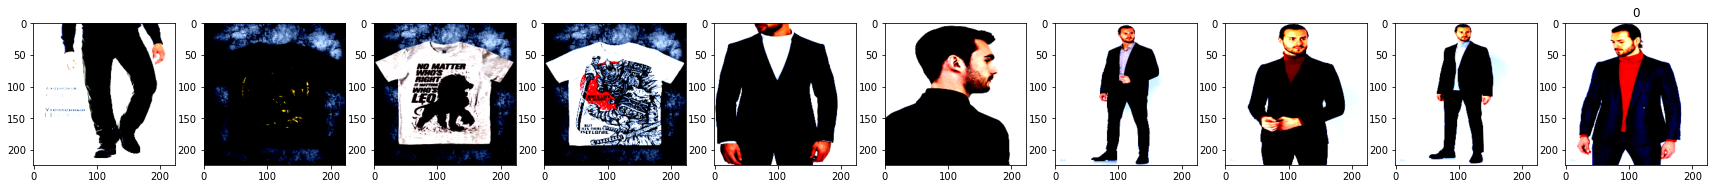

In [21]:
# посмотрим на пару из них
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
        axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
    axes[i].set_title(labels[i].numpy())
plt.show()

show_imgs(images, labels)

# Retraining baseline

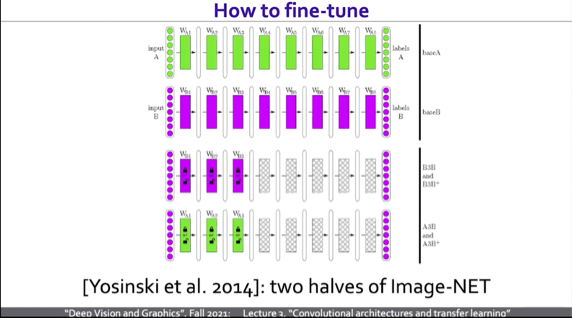

In [121]:
model_resnet = models.resnet18(pretrained=False)
# model_resnet.fc = nn.Linear(in_features=512, out_features=len(train_data.classes), bias=True)
teacher_model.fc = nn.Linear(in_features=512, out_features=len(train_data.classes), bias=True)
teacher_model.load_state_dict(torch.load('model_resnet18_clothes_class.pth'))
model_resnet = model_resnet.to(device)

In [122]:
torch.cuda.empty_cache()
import gc
gc.collect()

992

In [125]:
device = torch.device('cuda')

def train(net, n_epoch=2):
    loss_fn = torch.nn.CrossEntropyLoss()

    learning_rate = 1e-4
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # acc по test
    best_accuracy = 0
    for epoch in tqdm(range(n_epoch)):

        running_loss = 0.0
        
        for i, batch in enumerate(tqdm(train_loader)):
            X_batch, y_batch = batch
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()

            y_pred = net(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            if i % 1500 ==0:
                
                with torch.no_grad():
                    accuracy = []
                    for batch in test_loader:
                        x, y = batch
                        x = x.to(device)
                        y = y.to(device)
                        y_pred = net(x)
                        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
                    
                    accuracy = np.mean(np.array(accuracy))
                    if accuracy > best_accuracy:
                        print('New best model with test acc:', accuracy)
                        torch.save(net.state_dict(), './best_model.pt')
                        best_accuracy = accuracy

            
            running_loss += loss.item()
            scheduler.step()
            # every 50th batch printing loss
            if i % 50 == 49:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 50))
                running_loss = 0.0

    print('Training is finished')
    return net

In [ ]:
net = model_resnet.to(device)
train(net, n_epoch=50)

In [ ]:
labels_net = []
labels_true = []
for images, labels in test_loader:
    labels_true.extend(labels)
    labels_net.extend(net.forward(images.cuda()).detach().cpu().numpy())

accuracy_score(labels_true, np.argmax(np.array(labels_net), axis=1))

In [ ]:
torch.save(net.state_dict(), './resnet_classification_test.pth')

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

# Distilation process

In [ ]:
def loss_fn_kd(outputs, labels, teacher_outputs, alpha, T):

    # print(F.log_softmax(outputs/T, dim=1).size(), F.softmax(teacher_outputs/T, dim=1).size())
    # print(outputs.size(), labels.size())
    # KD_loss = nn.KLDivLoss((F.log_softmax(outputs/T, dim=1), F.softmax(teacher_outputs/T, dim=1)), reduction='batchmean') * (alpha * T * T) + F.cross_entropy(outputs, labels) * (1. - alpha)
    KD_loss = F.cross_entropy(outputs, labels) * (1. - alpha) + F.kl_div(F.log_softmax(outputs/T, dim=1), F.softmax(teacher_outputs/T, dim=1), reduction='batchmean') * (T * T) 
    # print(KD_loss.item())
    return KD_loss

In [ ]:
class RunningAverage():

    def __init__(self):
        self.steps = 0
        self.total = 0
    
    def update(self, val):
        self.total += val
        self.steps += 1
    
    def __call__(self):
        return self.total/float(self.steps)

In [ ]:
from torch.autograd import Variable
def train_kd(model, teacher_model, optimizer, loss_fn_kd, train_loader, test_loader, num_ep, alpha, T):
    # set model to training mode
    model = model.train()
    teacher_model = teacher_model.to(device).eval()
    
    # teacher_model = teacher_model.eval()
    best_accuracy = 0.
    loss_avg = RunningAverage()
    for ep in range(num_ep):
        print('Epoch', ep)
        # Use tqdm for progress bar
        with tqdm(total=len(train_loader)) as t:
            for i, (train_batch, labels_batch) in enumerate(train_loader):
                train_batch, labels_batch = train_batch.to(device), labels_batch.to(device)
                
                # compute model output, fetch teacher output, and compute KD loss
                output_batch = model(train_batch)

                # get one batch output from teacher_outputs list

                with torch.no_grad():
                    output_teacher_batch = teacher_model(train_batch)
                # print(output_teacher_batch)
                # output_teacher_batch = Variable(output_teacher_batch, requires_grad=False)
                
                # loss = loss_fn_kd(output_batch, labels_batch, output_teacher_batch, alpha, T)
                # print(output_batch.size())
                # print(labels.size())
                output_teacher_batch.requires_grad=False
                
                loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(output_batch/T, dim=1),
                                        F.softmax(output_teacher_batch/T, dim=1)) * (alpha * T * T) + \
                        F.cross_entropy(output_batch, labels_batch) * (1. - alpha)

                optimizer.zero_grad()
                loss.backward()

                # performs updates using calculated gradients
                optimizer.step()
                
                # update the average loss
                loss_avg.update(loss.item())

                t.set_postfix(loss='{:05.3f}'.format(loss_avg()))
                t.update()
                
                # if i %30:
                #     print('avg train loss', loss_avg())
                #     loss_avg = RunningAverage()
            

        accuracy = []
        for batch in test_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))

        accuracy = np.mean(np.array(accuracy))
        if accuracy > best_accuracy:
            print('New best model with test acc:', accuracy)
            torch.save(model.state_dict(), './best_model_student.pt')
            best_accuracy = accuracy

# Student model

In [ ]:
import torch.nn.functional as F

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3)

        # y = Wx + b
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(9216, 256)  # 9216 was found by launching
        self.fc2 = nn.Linear(256, 28)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)

        
        x = torch.flatten(x, 1) 
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [131]:
device = torch.device('cuda')
torch.cuda.empty_cache()
import gc
gc.collect()

student = Net().to(device)
train(student)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

New best model with test acc: 0.0334375
[1,    50] loss: 3.233
[1,   100] loss: 3.228
[1,   150] loss: 3.229


  0%|          | 0/198 [00:00<?, ?it/s]

New best model with test acc: 0.06
[2,    50] loss: 3.226
[2,   100] loss: 3.227
[2,   150] loss: 3.226
Обучение закончено


Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=9216, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=28, bias=True)
)

# Teacher model

In [135]:
teacher_model = models.resnet18(pretrained=False)
teacher_model.fc = nn.Linear(in_features=512, out_features=len(train_data.classes), bias=True)
teacher_model.load_state_dict(torch.load('model_resnet18_clothes_class.pth'))
teacher_model = teacher_model.to(device)
teacher_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [136]:
labels_net = []
labels_true = []
for images, labels in test_loader:
    labels_true.extend(labels)
    labels_net.extend(teacher_model.forward(images.to(device)).detach().cpu().numpy())

accuracy_score(labels_true, np.argmax(np.array(labels_net), axis=1))

0.6374027623432291

# DIstilation process

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

student = Net().to(device)
student

learning_rate = 1e-3
optimizer = torch.optim.Adam(student.parameters(), lr=learning_rate)
train_kd(student, teacher_model, optimizer, loss_fn_kd, train_loader, test_loader, 10, 0.2, 1.5)

In [ ]:
labels_net = []
labels_true = []
for images, labels in test_loader:
    labels_true.extend(labels)
    labels_net.extend(student.forward(images.to(device)).detach().cpu().numpy())

accuracy_score(labels_true, np.argmax(np.array(labels_net), axis=1))

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

# Student quantization

In [ ]:
from torch.quantization import convert
model_quantized = convert(student, inplace=False)

In [ ]:
labels_net = []
labels_true = []
for images, labels in test_loader:
    labels_true.extend(labels)
    labels_net.extend(model_quantized.forward(images.to(device)).detach().cpu().numpy())

accuracy_score(labels_true, np.argmax(np.array(labels_net), axis=1))

# Teacher quantization

In [ ]:
model_quantized_teacher = convert(teacher_model, inplace=False)

In [ ]:
labels_net = []
labels_true = []
for images, labels in test_loader:
    labels_true.extend(labels)
    labels_net.extend(model_quantized.forward(images.to(device)).detach().cpu().numpy())

accuracy_score(labels_true, np.argmax(np.array(labels_net), axis=1))

# 